In [1]:
# Imports here
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
from collections import OrderedDict
from time import time
import copy
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import skimage.io as io
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = '/kaggle/input/eurosat-dataset'
train_dir = data_dir + '/EuroSAT'

# Define your transformations
train_transforms = transforms.Compose([
    #transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [3]:
# Load a pre-trained network 
model = models.googlenet(pretrained=True)
model.name = "googlnet"
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 77.7MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [5]:
for param in model.parameters():
    param.requires_grad = False

In [6]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) 

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epochs = 5
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [19]:
def validation(model, testloader, criterion,device):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [20]:
def train(model, trainloader, validloader, criterion, optimizer, device, epochs, steps,print_every):
    print("Training process initializing .....\n")

    for e in range(epochs):
        running_loss = 0
        model.train() 
    
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            # Forward and backward passes
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, validloader, criterion, device)
            
                print("Epoch: {}/{} | ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
                running_loss = 0
                model.train()

    print("\nTraining process is now complete!!")
    return model


In [24]:
def train(model,steps,print_every,epochs):
    print("Training process initializing .....\n")

    for e in range(epochs):
        running_loss = 0
        model.train() 
    
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, validloader, criterion)
            
                print("Epoch: {}/{} | ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
                running_loss = 0
                model.train()

    print("\nTraining process is now complete!!")
    return model

In [21]:
model = train(model,trainloader, validloader,criterion, optimizer,device, epochs,steps, print_every)

Training process initializing .....

Epoch: 1/5 |  Training Loss: 1.9808 |  Validation Loss: 1.8633 |  Validation Accuracy: 0.5519
Epoch: 1/5 |  Training Loss: 1.7880 |  Validation Loss: 1.6808 |  Validation Accuracy: 0.5767
Epoch: 1/5 |  Training Loss: 1.6088 |  Validation Loss: 1.5399 |  Validation Accuracy: 0.6048
Epoch: 1/5 |  Training Loss: 1.5109 |  Validation Loss: 1.4248 |  Validation Accuracy: 0.6585
Epoch: 1/5 |  Training Loss: 1.4252 |  Validation Loss: 1.3418 |  Validation Accuracy: 0.6737
Epoch: 1/5 |  Training Loss: 1.3301 |  Validation Loss: 1.2681 |  Validation Accuracy: 0.6967
Epoch: 1/5 |  Training Loss: 1.2779 |  Validation Loss: 1.2140 |  Validation Accuracy: 0.7056
Epoch: 1/5 |  Training Loss: 1.2029 |  Validation Loss: 1.1555 |  Validation Accuracy: 0.7211
Epoch: 1/5 |  Training Loss: 1.1821 |  Validation Loss: 1.1092 |  Validation Accuracy: 0.7330
Epoch: 1/5 |  Training Loss: 1.1357 |  Validation Loss: 1.0870 |  Validation Accuracy: 0.7152
Epoch: 1/5 |  Training 

In [23]:
def pred(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [24]:
labels_fp32,predictions_fp32 = pred(model,testloader)

Time:  49.033143758773804
Accuracy achieved by the network on test images is: 82%


In [25]:
import seaborn as sns
def metrics(labels,predictions):
    classes = train_data.dataset.classes
    cm = confusion_matrix(np.array(labels), np.array(predictions))
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print('----------------------------------------------------------------')
    print("Classification Report:")
    report = classification_report(np.array(labels),np.array(predictions))
    print(report)

Confusion Matrix:


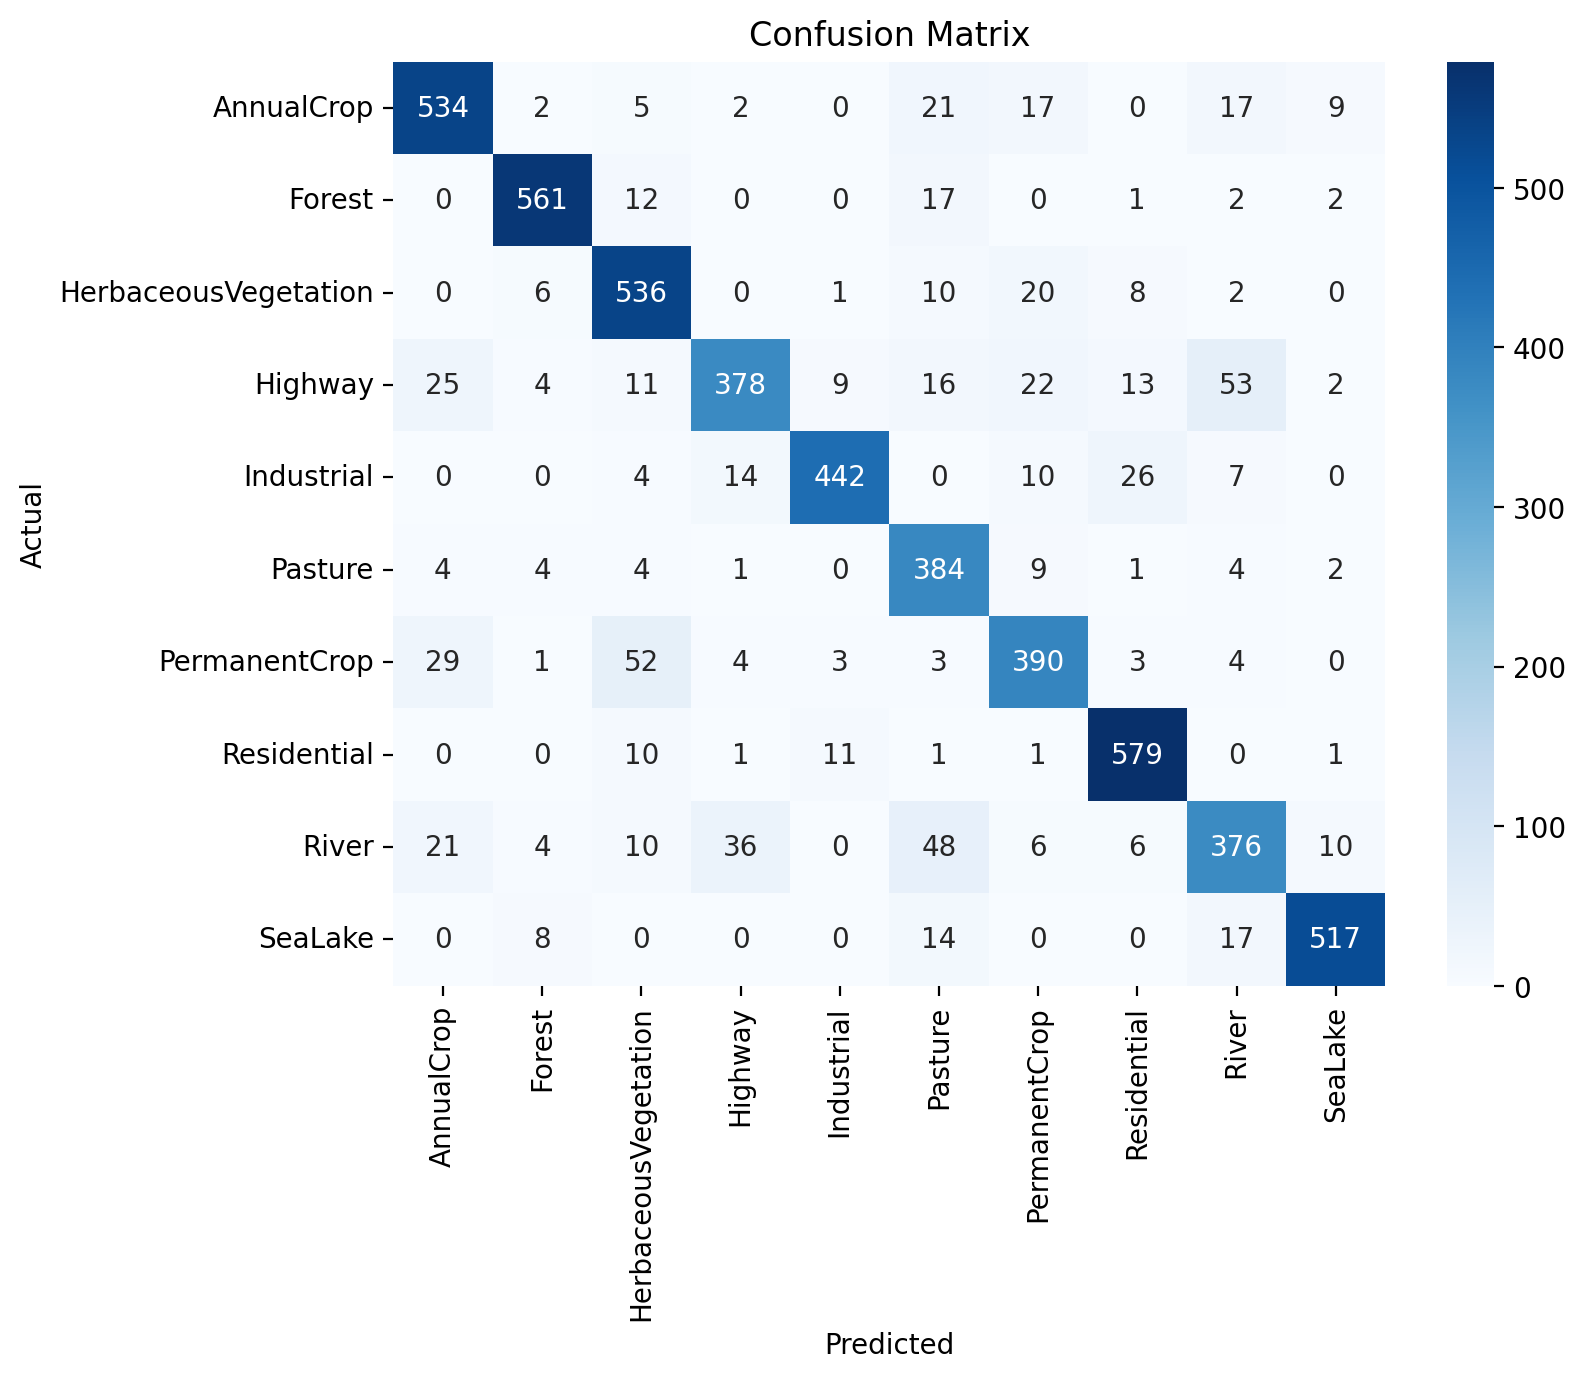

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       607
           1       0.95      0.94      0.95       595
           2       0.83      0.92      0.87       583
           3       0.87      0.71      0.78       533
           4       0.95      0.88      0.91       503
           5       0.75      0.93      0.83       413
           6       0.82      0.80      0.81       489
           7       0.91      0.96      0.93       604
           8       0.78      0.73      0.75       517
           9       0.95      0.93      0.94       556

    accuracy                           0.87      5400
   macro avg       0.87      0.87      0.87      5400
weighted avg       0.87      0.87      0.87      5400



In [117]:
metrics(labels_fp32,predictions_fp32)

In [27]:
import os
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [28]:
print("Size of fp32 model:",end='')
print_model_size(model)

Size of fp32 model:22.60 MB


# Quantization

# FP-16

In [34]:
model_fp16 = copy.deepcopy(model)

In [35]:
model_fp16.half()
model_fp16.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [36]:
def pred_fp16(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.half())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [37]:
labels_fp16,predictions_fp16 = pred_fp16(model_fp16,testloader)

Time:  19.07857656478882
Accuracy achieved by the network on test images is: 82%


Confusion Matrix:


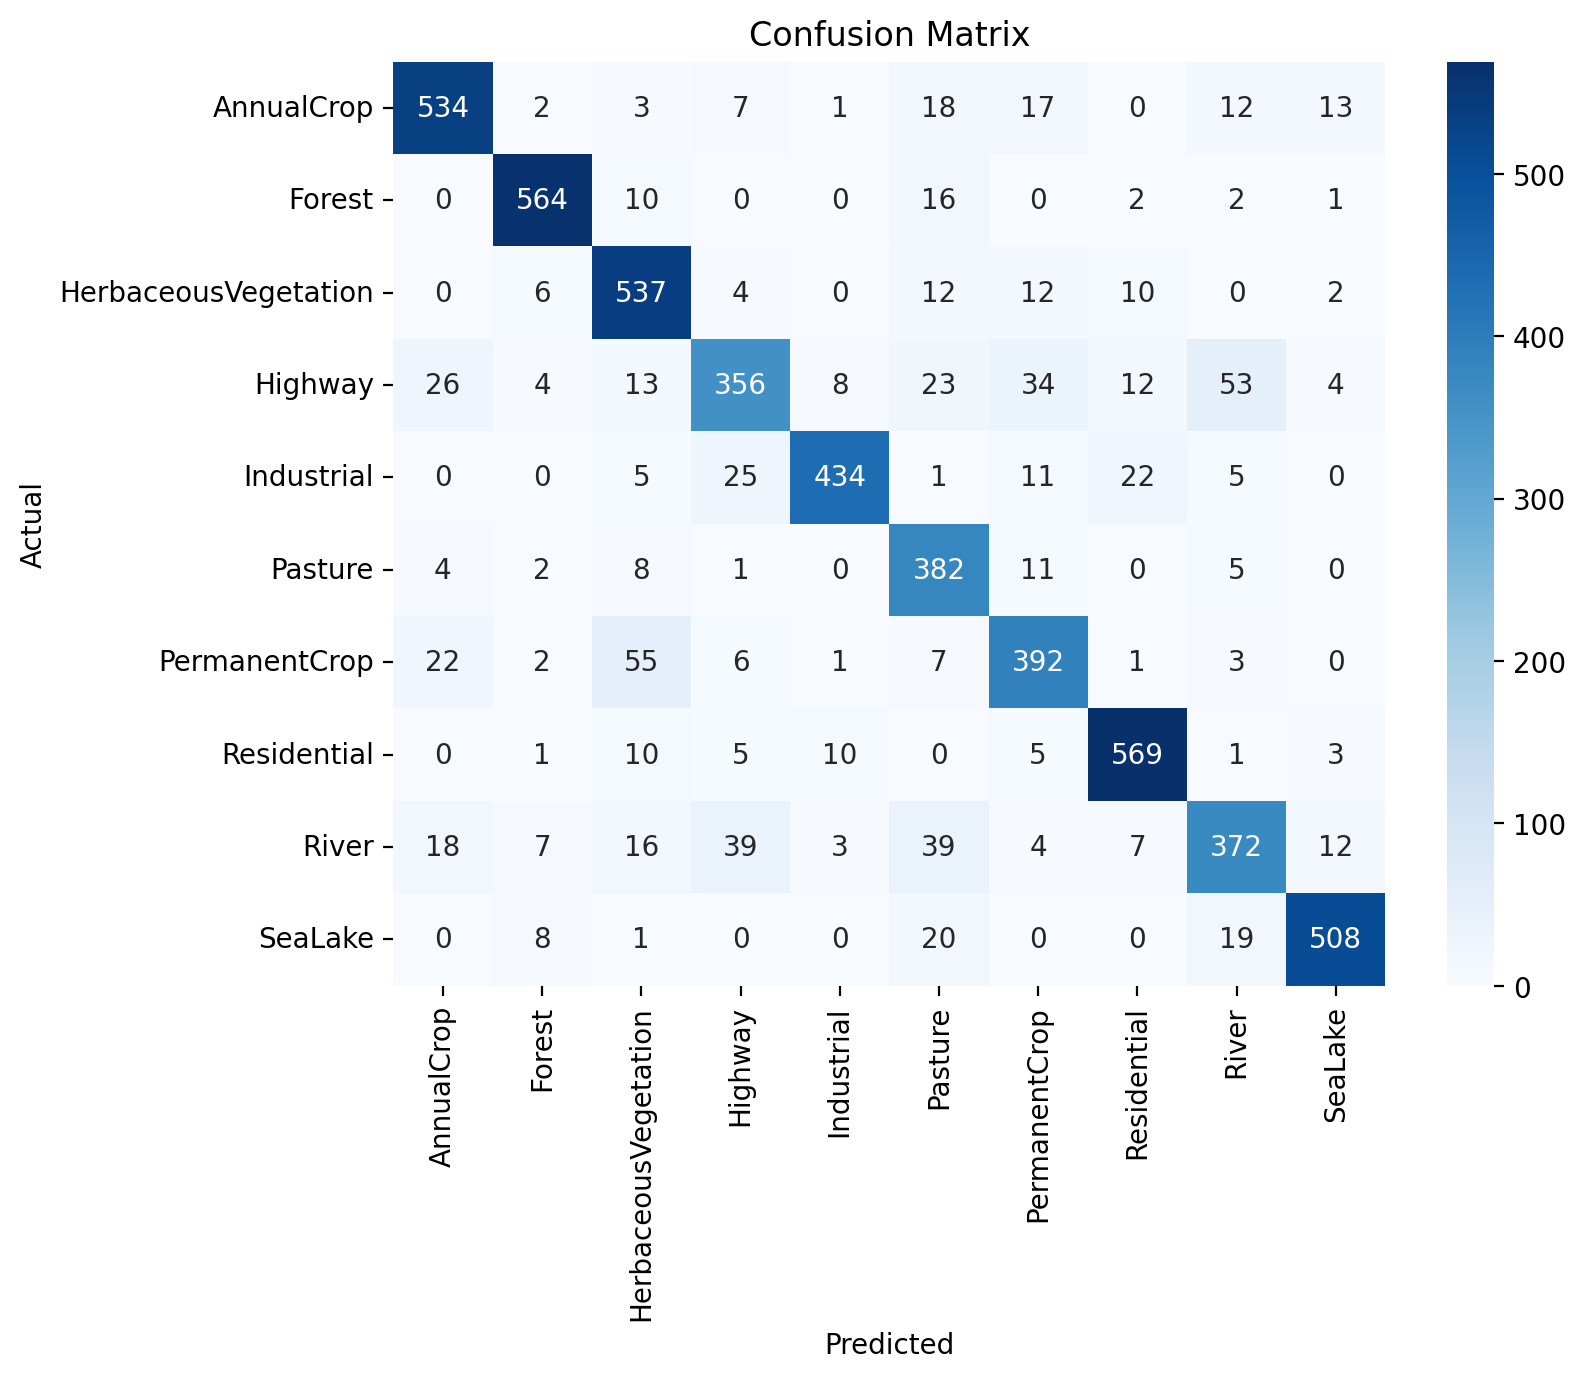

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       607
           1       0.95      0.95      0.95       595
           2       0.82      0.92      0.87       583
           3       0.80      0.67      0.73       533
           4       0.95      0.86      0.90       503
           5       0.74      0.92      0.82       413
           6       0.81      0.80      0.80       489
           7       0.91      0.94      0.93       604
           8       0.79      0.72      0.75       517
           9       0.94      0.91      0.92       556

    accuracy                           0.86      5400
   macro avg       0.86      0.86      0.86      5400
weighted avg       0.86      0.86      0.86      5400



In [124]:
metrics(labels_fp16,predictions_fp16)

# FP-64

In [38]:
model_64 = copy.deepcopy(model)
model_64.double()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [43]:
for name, param in weights_64.items():
    print(name)

conv1.conv.weight
conv1.bn.weight
conv1.bn.bias
conv1.bn.running_mean
conv1.bn.running_var
conv1.bn.num_batches_tracked
conv2.conv.weight
conv2.bn.weight
conv2.bn.bias
conv2.bn.running_mean
conv2.bn.running_var
conv2.bn.num_batches_tracked
conv3.conv.weight
conv3.bn.weight
conv3.bn.bias
conv3.bn.running_mean
conv3.bn.running_var
conv3.bn.num_batches_tracked
inception3a.branch1.conv.weight
inception3a.branch1.bn.weight
inception3a.branch1.bn.bias
inception3a.branch1.bn.running_mean
inception3a.branch1.bn.running_var
inception3a.branch1.bn.num_batches_tracked
inception3a.branch2.0.conv.weight
inception3a.branch2.0.bn.weight
inception3a.branch2.0.bn.bias
inception3a.branch2.0.bn.running_mean
inception3a.branch2.0.bn.running_var
inception3a.branch2.0.bn.num_batches_tracked
inception3a.branch2.1.conv.weight
inception3a.branch2.1.bn.weight
inception3a.branch2.1.bn.bias
inception3a.branch2.1.bn.running_mean
inception3a.branch2.1.bn.running_var
inception3a.branch2.1.bn.num_batches_tracked
ince

In [54]:
weights_64 = model_64.state_dict()
print(weights_64['conv1.conv.weight'].dtype)
# print(weights_64['conv1.weight'].dtype)

torch.float64


In [55]:
model_64.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

model_64.to(device)

In [57]:
def pred_fp64(Model,Testloader): 
    all_labels = [] 
    all_predictions = [] 
    correct = 0 
    total = 0 
    start_time = time() 
    with torch.no_grad(): 
        Model.eval() 
        for images, labels in Testloader: 
            all_labels.extend(labels.numpy()) 
            images, labels = images.to(device), labels.to(device) 
            outputs = Model(images.double())
            _,predicted = torch.max(outputs.data, 1) 
            total += labels.size(0) 
            correct += (predicted == labels).sum().item() 
            predicted_tensor_cpu = predicted.to('cpu') 
            all_predictions.extend(predicted_tensor_cpu.numpy()) 
        end_time = time() 
        print("Time: ",end_time - start_time) 
        print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
        return all_labels,all_predictions

def pred_fp64(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.double())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [59]:
labels_64,predictions_64 = pred_fp64(model_64,testloader)

Time:  118.58471155166626
Accuracy achieved by the network on test images is: 81%


 labels,predictions = pred_fp64(model_64,testloader)

Confusion Matrix:


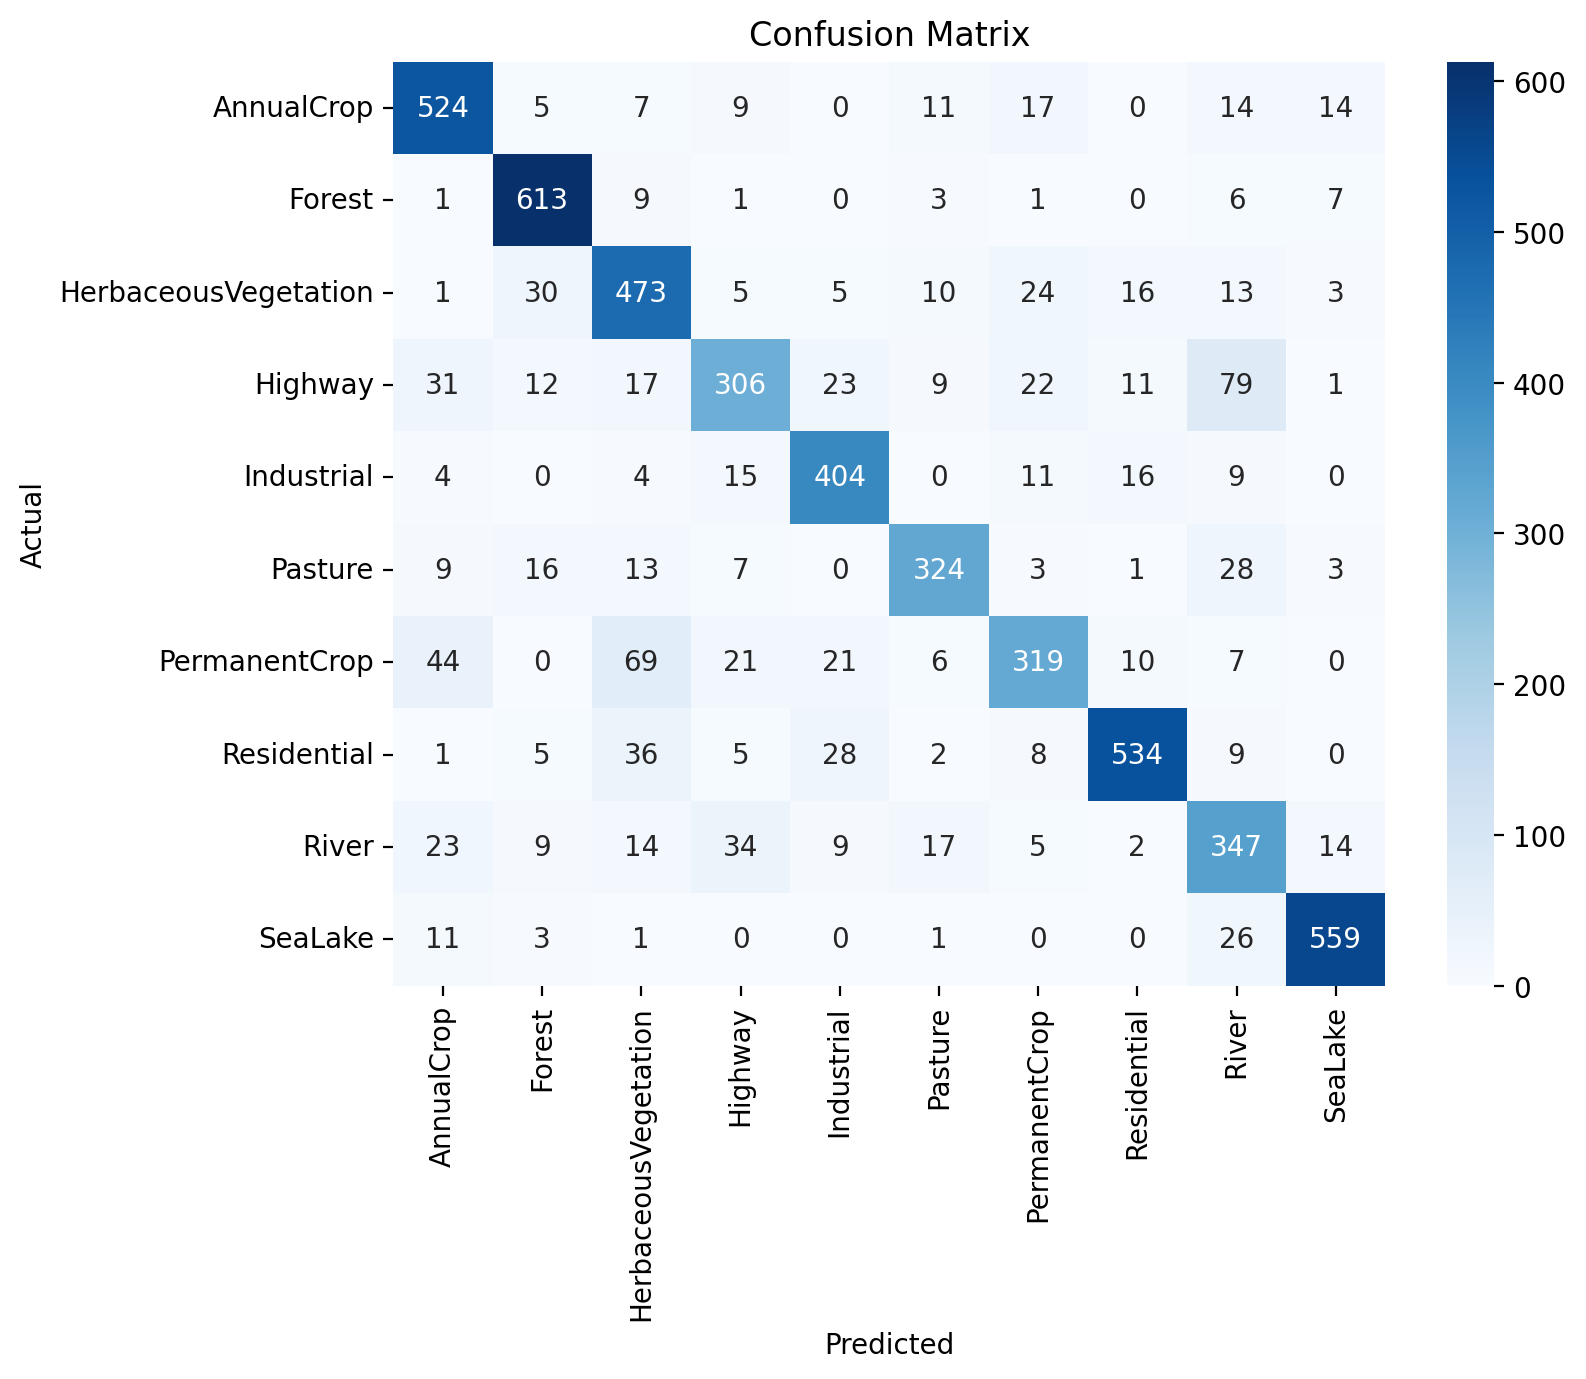

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       601
           1       0.88      0.96      0.92       641
           2       0.74      0.82      0.77       580
           3       0.76      0.60      0.67       511
           4       0.82      0.87      0.85       463
           5       0.85      0.80      0.82       404
           6       0.78      0.64      0.70       497
           7       0.91      0.85      0.88       628
           8       0.64      0.73      0.69       474
           9       0.93      0.93      0.93       601

    accuracy                           0.82      5400
   macro avg       0.81      0.81      0.81      5400
weighted avg       0.82      0.82      0.81      5400



In [61]:
metrics(labels_64,predictions_64)

## INT-8

In [65]:
import torch
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx

### PTQ

In [66]:
model.to('cpu')

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [67]:
input_data = next(iter(trainloader))[0] 
calibrate_data = input_data.to("cpu")

In [68]:
model_int8 = copy.deepcopy(model)

qconfig_mapping = get_default_qconfig_mapping("x86")
model_int8.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_int8, qconfig_mapping, calibrate_data)
# calibrate

/opt/conda/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [69]:
with torch.no_grad():
    for i in range(20):
        batch = next(iter(trainloader))[0]
        output = model_prepared(batch.to('cpu'))

In [70]:
model_quantized_static = quantize_fx.convert_fx(model_prepared)
model_quantized_static.state_dict()

OrderedDict([('_scale_0', tensor(0.0314)),
             ('_zero_point_0', tensor(55)),
             ('_scale_4', tensor(0.0294)),
             ('_zero_point_4', tensor(45)),
             ('_scale_8', tensor(0.0266)),
             ('_zero_point_8', tensor(27)),
             ('conv1.conv.weight',
              tensor([[[[ 1.7493e-01,  3.7173e-01,  6.5599e-02,  ...,  0.0000e+00,
                          2.1866e-02, -4.3733e-02],
                        [ 1.5306e-01,  2.4053e-01, -8.7465e-01,  ...,  3.4986e-01,
                          2.6240e-01, -2.1866e-02],
                        [ 1.0933e-01, -8.7465e-01, -1.2682e+00,  ...,  1.2464e+00,
                          4.3733e-02, -2.1866e-02],
                        ...,
                        [ 0.0000e+00,  6.9972e-01,  1.2682e+00,  ..., -1.2245e+00,
                         -6.5599e-02,  4.3733e-02],
                        [ 1.0933e-01,  3.4986e-01, -2.8426e-01,  ..., -1.7493e-01,
                          2.4053e-01,  1.3120e-01],


In [71]:
model_quantized_static

GraphModule(
  (conv1): Module(
    (conv): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.12174944579601288, zero_point=0, padding=(3, 3))
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Module(
    (conv): QuantizedConvReLU2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.08723582327365875, zero_point=0)
  )
  (conv3): Module(
    (conv): QuantizedConvReLU2d(64, 192, kernel_size=(3, 3), stride=(1, 1), scale=0.0879252627491951, zero_point=0, padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Module(
    (branch1): Module(
      (conv): QuantizedConvReLU2d(192, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.08945435285568237, zero_point=0)
    )
    (branch2): Module(
      (0): Module(
        (conv): QuantizedConvReLU2d(192, 96, kernel_size=(1, 1), stride=(1, 1), scale=0.06701117753982544, zero_point=0)
      )
      (1): Module(


In [72]:
model_quantized_static.to('cpu')

GraphModule(
  (conv1): Module(
    (conv): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.12174944579601288, zero_point=0, padding=(3, 3))
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Module(
    (conv): QuantizedConvReLU2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.08723582327365875, zero_point=0)
  )
  (conv3): Module(
    (conv): QuantizedConvReLU2d(64, 192, kernel_size=(3, 3), stride=(1, 1), scale=0.0879252627491951, zero_point=0, padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Module(
    (branch1): Module(
      (conv): QuantizedConvReLU2d(192, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.08945435285568237, zero_point=0)
    )
    (branch2): Module(
      (0): Module(
        (conv): QuantizedConvReLU2d(192, 96, kernel_size=(1, 1), stride=(1, 1), scale=0.06701117753982544, zero_point=0)
      )
      (1): Module(


In [73]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_static.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_static(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  92.29466342926025
Accuracy achieved by the network on test images is: 76%


Confusion Matrix:


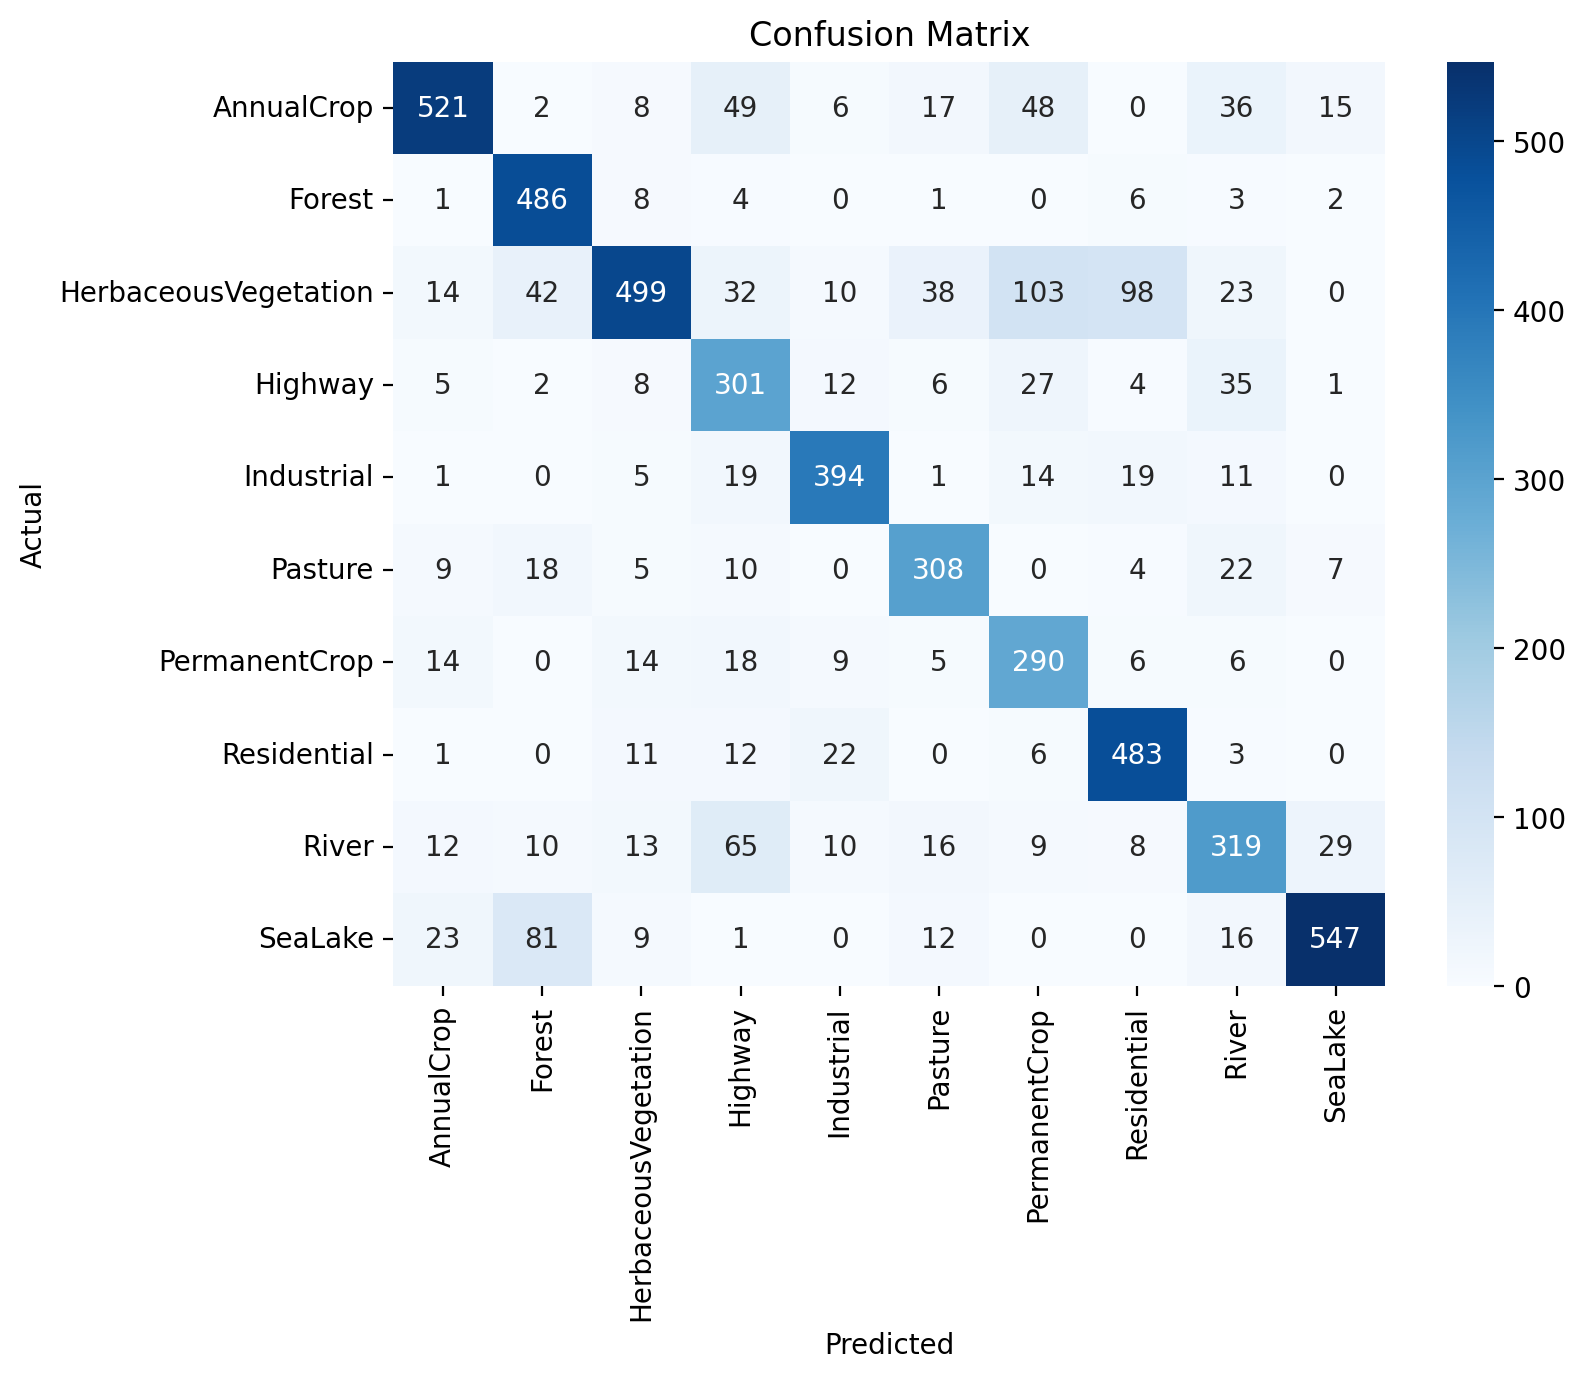

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       702
           1       0.76      0.95      0.84       511
           2       0.86      0.58      0.69       859
           3       0.59      0.75      0.66       401
           4       0.85      0.85      0.85       464
           5       0.76      0.80      0.78       383
           6       0.58      0.80      0.68       362
           7       0.77      0.90      0.83       538
           8       0.67      0.65      0.66       491
           9       0.91      0.79      0.85       689

    accuracy                           0.77      5400
   macro avg       0.76      0.78      0.76      5400
weighted avg       0.79      0.77      0.77      5400



In [75]:
metrics(all_predictions_int8,all_labels_int8)

### QAT

Load a new vgg model which is not trained before starting qat

In [76]:
input_data = next(iter(trainloader))[0]
calibrate_data = input_data.to(device)

In [77]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model.train()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [78]:
qconfig_mapping = get_default_qat_qconfig_mapping("x86")
model_prepared = quantize_fx.prepare_qat_fx(model, qconfig_mapping, calibrate_data)

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [79]:
model_prepared.to(device)

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
  (activation_post_process_1): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
  (activation_post_process_2): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor

In [ ]:
model = train(model,trainloader, validloader,criterion, optimizer,device, epochs,steps, print_every)

In [81]:
model_prepared = train(model_prepared,trainloader, validloader,criterion, optimizer,device,epochs,steps,print_every)

Training process initializing .....



/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:677.)
  return torch.fused_moving_avg_obs_fake_quant(


Epoch: 1/5 |  Training Loss: 0.9274 |  Validation Loss: 1.1331 |  Validation Accuracy: 0.6148
Epoch: 1/5 |  Training Loss: 1.0739 |  Validation Loss: 1.2400 |  Validation Accuracy: 0.5696
Epoch: 1/5 |  Training Loss: 1.0382 |  Validation Loss: 1.1311 |  Validation Accuracy: 0.5922
Epoch: 1/5 |  Training Loss: 0.9984 |  Validation Loss: 1.0223 |  Validation Accuracy: 0.6385
Epoch: 1/5 |  Training Loss: 0.9671 |  Validation Loss: 0.9986 |  Validation Accuracy: 0.6504
Epoch: 1/5 |  Training Loss: 0.9449 |  Validation Loss: 0.9068 |  Validation Accuracy: 0.7030
Epoch: 1/5 |  Training Loss: 0.9738 |  Validation Loss: 0.9087 |  Validation Accuracy: 0.6919
Epoch: 1/5 |  Training Loss: 0.9316 |  Validation Loss: 0.8522 |  Validation Accuracy: 0.7204
Epoch: 1/5 |  Training Loss: 0.9038 |  Validation Loss: 0.8577 |  Validation Accuracy: 0.7148
Epoch: 1/5 |  Training Loss: 0.8943 |  Validation Loss: 0.8685 |  Validation Accuracy: 0.6996
Epoch: 1/5 |  Training Loss: 0.9195 |  Validation Loss: 0.83

In [ ]:
model_prepared.to('cpu')

In [147]:
model_quantized_trained = quantize_fx.convert_fx(model_prepared)

In [148]:
model_quantized_trained.to('cpu')

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.09158783406019211, zero_point=0, padding=(1, 1))
    (2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.12281331419944763, zero_point=0, padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.13946717977523804, zero_point=0, padding=(1, 1))
    (7): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.18906207382678986, zero_point=0, padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.28109076619148254, zero_point=0, padding=(1, 1))
    (12): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.3341525197029114, zero_point=0, padding=(1, 1))
    (14): Quanti

In [149]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_trained.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_trained(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  679.332807302475
Accuracy achieved by the network on test images is: 64%


Confusion Matrix:


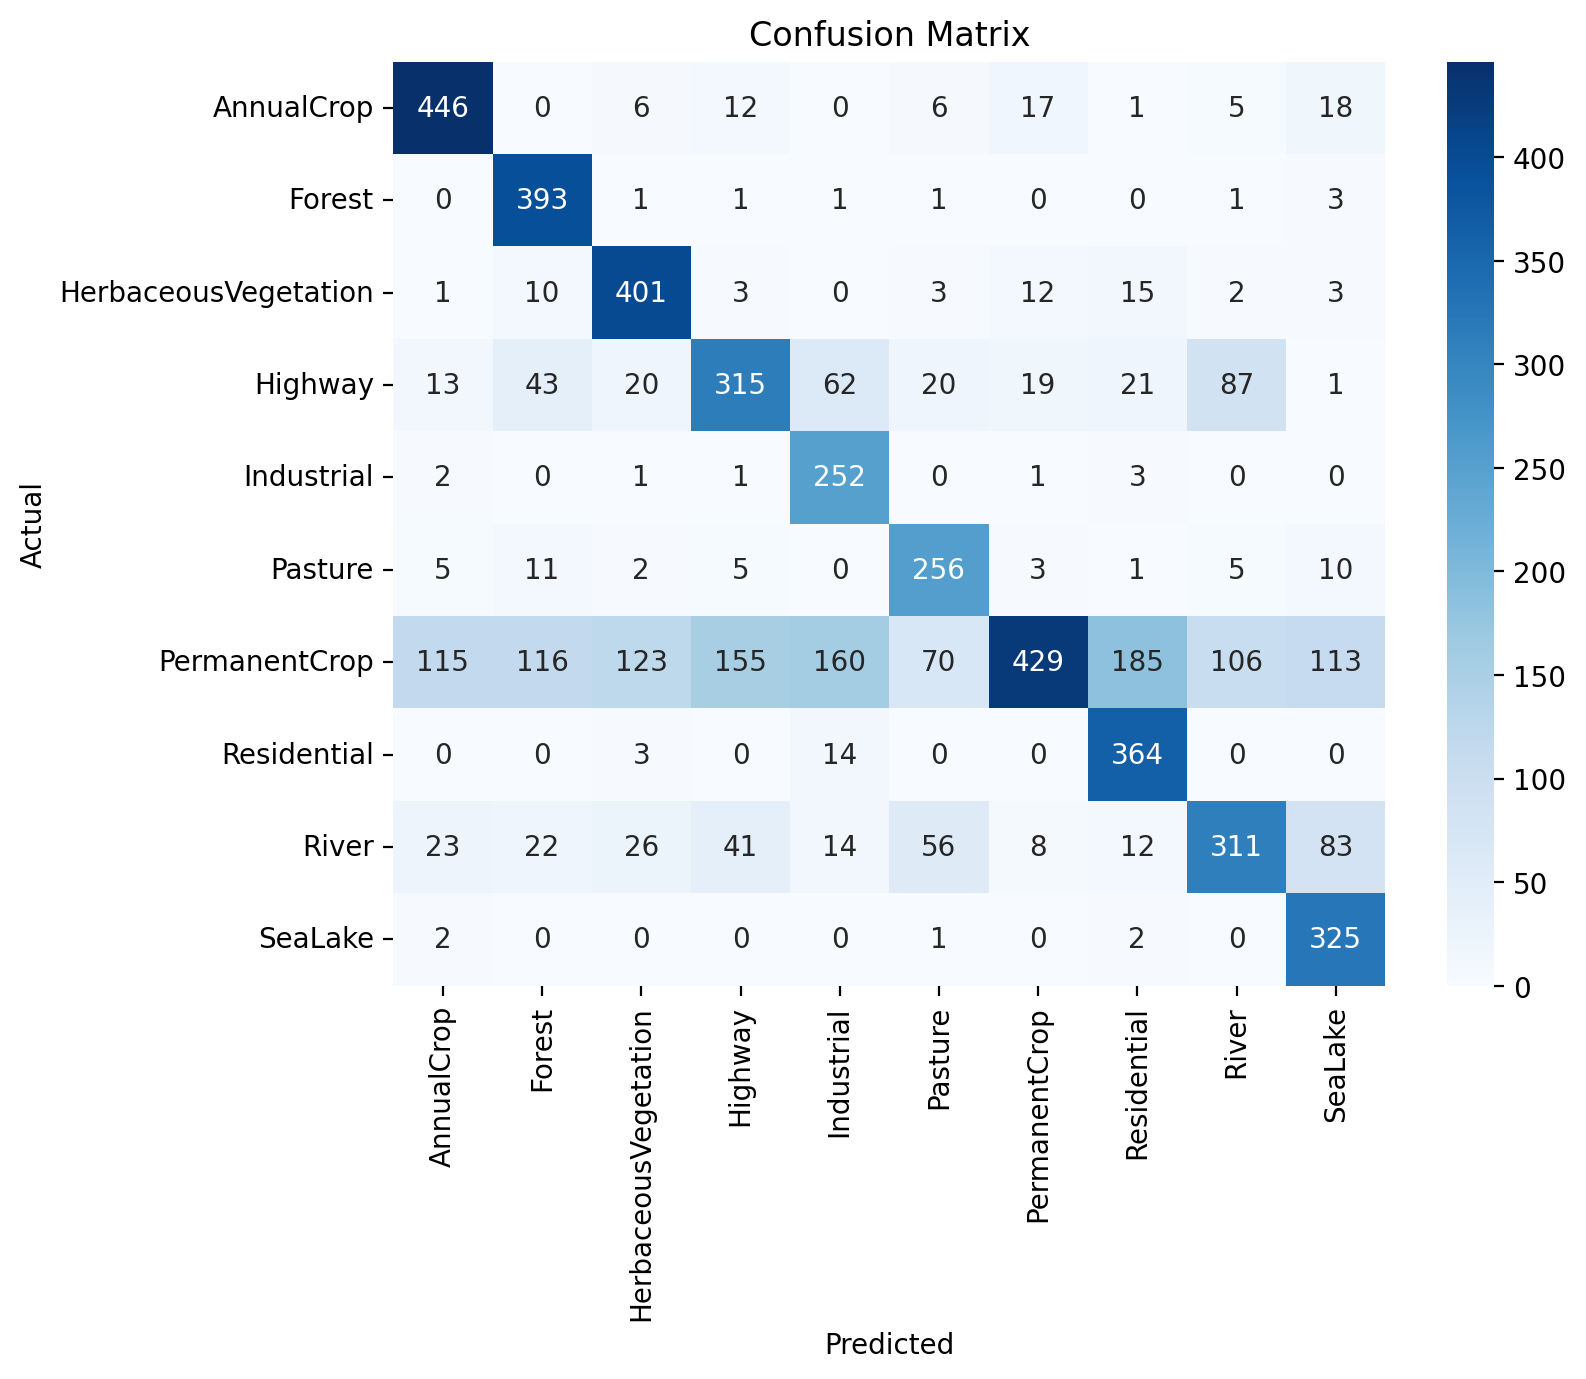

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.80       511
           1       0.66      0.98      0.79       401
           2       0.69      0.89      0.78       450
           3       0.59      0.52      0.56       601
           4       0.50      0.97      0.66       260
           5       0.62      0.86      0.72       298
           6       0.88      0.27      0.42      1572
           7       0.60      0.96      0.74       381
           8       0.60      0.52      0.56       596
           9       0.58      0.98      0.73       330

    accuracy                           0.65      5400
   macro avg       0.65      0.78      0.67      5400
weighted avg       0.70      0.65      0.61      5400



In [150]:
metrics(all_predictions_int8,all_labels_int8)

In [151]:
print("Size of fp16 model:",end='')
print_model_size(model_fp16)
print("Size of PTQ model:",end='')
print_model_size(model_quantized_static)
print("Size of QAT model:",end='')
print_model_size(model_quantized_trained)

Size of fp16 model:239.47 MB
Size of PTQ model:119.99 MB
Size of QAT model:119.99 MB
